In [31]:
import awkward as ak
import uproot
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import math

sys.path.append('/home/jbohm/start_tf/LCStudies')
from  util import graph_util as gu
from data import particle_data_visualize_plot_utils as pu
%matplotlib inline


In [45]:
# by generic definition of spherical to cartesian coord conversion
def spherical_to_cartesian(rs, thetas, phis):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.sin(phis[i])*np.cos(thetas[i]))
        y.append(r*np.sin(phis[i])*np.sin(thetas[i]))
        z.append(r*np.cos(phis[i]))

    return x,y,z

# load and process pion file
pion_dir = "/fast_scratch_1/jbohm/train_testing_data/pion_files"
pi0_file_num = 14
pipm1_file_num = 13
pipm2_file_num = 14
len_file = 6000
i_max = 1
energy_threshold = 0

# load cell geo tree dict
file = uproot.open("/data/atlas/data/rho_delta/rho_small.root")
cell_geo_tree = file["CellGeo"]

node_feature_names = cell_geo_tree.keys()[1:7] # 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi'

file_names = ["/pi0_" + str(pi0_file_num) + "_pipm_" + str(pipm1_file_num) + "_" + str(pipm2_file_num) + "_len_" + str(len_file) + "_i_" + str(i) + ".npy" for i in range(i_max)]

cell_geo_data = cell_geo_tree.arrays(library='np')
cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
sorter = np.argsort(cell_geo_ID)

# cluster data dict to look up data by feature name
processed_event_data = {}

cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
num_cells = 0

for feature in [*node_feature_names, 'x', 'y', 'z', 'truth_EM_frac', 'cluster_cell_E', 'cluster_cell_truth_E', 'cell_hits_E_EM', 'cell_hits_E_non_EM', 'truth_particle']:
    processed_event_data[feature] = []

for file_name in file_names:
    event_data = np.load(pion_dir + file_name, allow_pickle=True).item()
    num_events = len(event_data["eventNumber"])

    for event_idx in range(num_events):
        num_clusters = event_data["nCluster"][event_idx]

        # append empty array for all cells in an event
        for cluster_idx in range(num_clusters):
            cell_IDs = event_data['cluster_cell_ID'][event_idx][cluster_idx]

            # get truth enery (EM/nonEM)
            cell_hits_E_EM = np.array(event_data["cluster_cell_hitsE_EM"][event_idx][cluster_idx])
            cell_hits_E_non_EM = np.array(event_data["cluster_cell_hitsE_nonEM"][event_idx][cluster_idx])
            cell_hits_E = cell_hits_E_EM + cell_hits_E_non_EM

            # filter out cells with truth energy of 0
            threshold_E = cell_hits_E > energy_threshold

            cell_IDs = cell_IDs[threshold_E]
            num_cells += len(cell_IDs)
            cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

            # get truth energy fraction EM/EM + nonEM for each cell
            truth_EM_frac = cell_hits_E_EM[threshold_E] / cell_hits_E[threshold_E]
            cell_hits_E =  cell_hits_E[threshold_E]
            cell_hits_E_EM = cell_hits_E_EM[threshold_E]
            cell_hits_E_non_EM = cell_hits_E_non_EM[threshold_E]

            # get cluster cell energy
            cluster_cell_E = event_data["cluster_cell_E"][event_idx][cluster_idx][threshold_E]

            # node features
            node_features = {}
            for feature in node_feature_names:
                node_features[feature] = cell_geo_data[feature][0][cell_ID_map]

            # get cartesian coords
            thetas = [2*np.arctan(np.exp(-eta)) for eta in node_features["cell_geo_eta"]]
            x, y, z = spherical_to_cartesian(node_features["cell_geo_rPerp"], node_features["cell_geo_phi"], thetas)

            # get target particle - 0 for pi0 [111], 1 for pi+/- [-111]
            truth_particle = 0 if event_data["truthPartPdgId"][event_idx][0] == 111 else 1

            """
            if truth_particle == 0 and np.mean(truth_EM_frac) < 0.8:
                print("event:", event_data["eventNumber"][event_idx], "clus idx:", cluster_idx)
                print("part ids:", event_data["truthPartPdgId"][event_idx])
                print("nonEM hits:", event_data["cluster_cell_hitsE_nonEM"][event_idx][cluster_idx])
                print("EM hits:", event_data["cluster_cell_hitsE_EM"][event_idx][cluster_idx])
                print("truth E:", event_data["truthPartE"][event_idx])
            """
            
            # if grouped by clusters append the set of clusters points
            if num_cells != 0:
                processed_event_data["truth_EM_frac"].append(truth_EM_frac)
                processed_event_data["cluster_cell_E"].append(cluster_cell_E)
                processed_event_data["cluster_cell_truth_E"].append(cell_hits_E)
                processed_event_data["cell_hits_E_EM"].append(cell_hits_E_EM)
                processed_event_data["cell_hits_E_non_EM"].append(cell_hits_E_non_EM)

                for feature in node_feature_names:
                    processed_event_data[feature].append(node_features[feature])

                processed_event_data["x"].append(x)
                processed_event_data["y"].append(y)
                processed_event_data["z"].append(z)

                processed_event_data["truth_particle"].append(truth_particle)
                
                num_cells = 0
# takes ~7 min for 50 files?
# takes ~ 7s for 1 file

Energy analysis

mean num cell hits 59.74632786533719


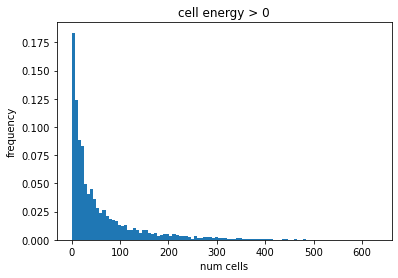

In [39]:
# plot average number of cell hits at different thresholds of energy hits
num_cell_hits = [len(processed_event_data["truth_EM_frac"][i]) for i in range(len(processed_event_data["truth_EM_frac"]))]
print("mean num cell hits", np.mean(num_cell_hits))
pu.plot_hist(num_cell_hits, 100, "cell energy > 0", "num cells", "frequency")

total num cells: 251426
max energy 776.50397
mean energy 0.5972157
mean energy 0.23247255
frac cells cut: 0.9927573122906939


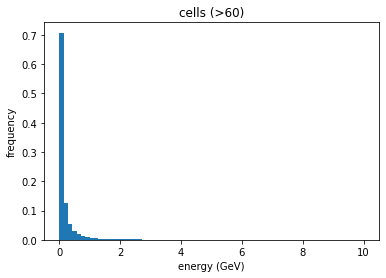

total num cells: 305828
max energy 1133.3536
mean energy 3.1935885
mean energy 0.6218644
frac cells cut: 0.9579959977503695


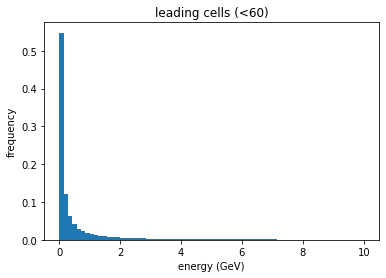

In [40]:
# plot cell total truth energy range
SPLIT_AT = 60

cell_truth_E = np.array([cell for clus_group in processed_event_data["cluster_cell_truth_E"] for cell in clus_group[SPLIT_AT:]])
tot_cells = len(cell_truth_E)
print("total num cells:", tot_cells)
print("max energy", np.max(cell_truth_E))
print("mean energy", np.mean(cell_truth_E))
cell_truth_E = cell_truth_E[cell_truth_E < 10]
#print("min energy:", np.min(cell_truth_E))
print("mean energy", np.mean(cell_truth_E))
print("frac cells cut:", len(cell_truth_E) / tot_cells)
pu.plot_hist(cell_truth_E, 70, "cells (>" + str(SPLIT_AT) +")", "energy (GeV)", "frequency")

cell_truth_E = np.array([ cell for clus_group in processed_event_data["cluster_cell_truth_E"] for cell in clus_group[:SPLIT_AT] ])
tot_cells = len(cell_truth_E)
print("total num cells:", tot_cells)
print("max energy", np.max(cell_truth_E))
print("mean energy", np.mean(cell_truth_E))
cell_truth_E = cell_truth_E[cell_truth_E < 10]
#print("min energy:", np.min(cell_truth_E))
print("mean energy", np.mean(cell_truth_E))
print("frac cells cut:", len(cell_truth_E) / tot_cells)
pu.plot_hist(cell_truth_E, 70, "leading cells (<" + str(SPLIT_AT) +")", "energy (GeV)", "frequency")

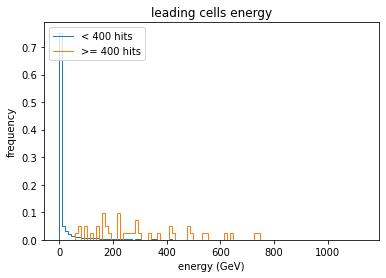

In [41]:
# plot leading cell energy for clus with # cell hits > threshold
thresh_hits = 400
lead_num = 0
leading_cell_energy = np.array([clus_group[lead_num] for clus_group in processed_event_data["cluster_cell_truth_E"]])

cut_less_hits = np.array(num_cell_hits) < thresh_hits
cut_more_hits = np.array(num_cell_hits) >= thresh_hits

pu.plot_overlay_hist([leading_cell_energy[cut_less_hits], leading_cell_energy[cut_more_hits]], 100, "leading cells energy", "energy (GeV)", "frequency", ["< " + str(thresh_hits) + " hits", ">= " + str(thresh_hits) + " hits"])

mean: 49.78739144419428


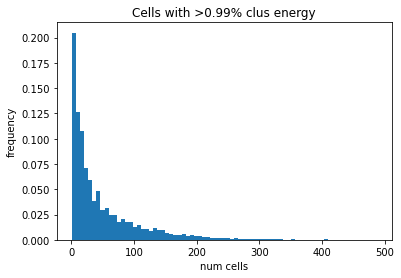

mean: 0.9995279


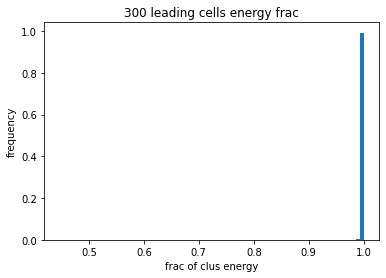

frac with <0.99 of clus energy in 300 leading cells: 0.007076230299131554


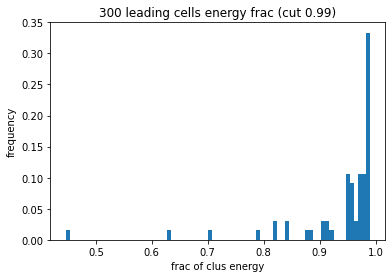

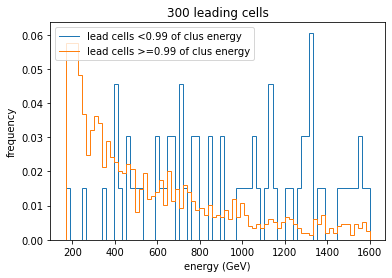

In [43]:
# how many cells contain 99% of the clusters energy
energy_frac = 0.99
num_cells = np.zeros(len(processed_event_data["truth_particle"]))
clus_energies = np.zeros(len(processed_event_data["truth_particle"]))
for clus_idx in range(len(num_cells)):
    clus_energy = np.sum(processed_event_data["cluster_cell_truth_E"][clus_idx])
    clus_energies[clus_idx] = clus_energy
    clus_lead_energy = 0
    cell_idx = 0
    while clus_lead_energy < energy_frac*clus_energy:
        clus_lead_energy += processed_event_data["cluster_cell_truth_E"][clus_idx][cell_idx]
        cell_idx += 1
    num_cells[clus_idx] = cell_idx

print("mean:", np.mean(num_cells))
pu.plot_hist(num_cells, 75, "Cells with >" + str(energy_frac) + "% clus energy", "num cells", "frequency")

# if take 60 leading cells what percent of energy is present
num_cells_cut = 300
cut_clus_energy_frac = 0.99

clus_energy_frac = np.array([np.sum(clus_cell_truth_E[:num_cells_cut]) / np.sum(clus_cell_truth_E) for clus_cell_truth_E in processed_event_data["cluster_cell_truth_E"]])
print("mean:", np.mean(clus_energy_frac))
pu.plot_hist(clus_energy_frac, 75, str(num_cells_cut) + " leading cells energy frac", "frac of clus energy", "frequency")

# if take 200 leading cells what is the distribution of frac energy less than 99 ?
print("frac with <" + str(cut_clus_energy_frac) + " of clus energy in " + str(num_cells_cut) + " leading cells:", len(clus_energy_frac[clus_energy_frac < cut_clus_energy_frac]) / len(clus_energy_frac))
pu.plot_hist(clus_energy_frac[clus_energy_frac < cut_clus_energy_frac], 75, str(num_cells_cut) + " leading cells energy frac (cut " + str(cut_clus_energy_frac) + ")", "frac of clus energy", "frequency")

pu.plot_overlay_hist([clus_energies[clus_energy_frac < cut_clus_energy_frac], clus_energies[clus_energy_frac >= cut_clus_energy_frac]], 75, str(num_cells_cut) + " leading cells", "energy (GeV)", "frequency", ["lead cells <" + str(cut_clus_energy_frac) + " of clus energy", "lead cells >=" + str(cut_clus_energy_frac) + " of clus energy"])


In [46]:
def plot_proccessed_cells_in_line(x,y,z,cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, vmin=None, vmax=None, same_axis=True):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(5*len(cell_data), 5)
    for i, cell_data_i in enumerate(cell_data):
        ax = fig.add_subplot(1, len(cell_data), i + 1, projection='3d')
        x_i = x[i] if len(x) > 1 else x[0]
        y_i = y[i] if len(y) > 1 else y[0]
        z_i = z[i] if len(z) > 1 else z[0]
        xlabel_i = xlabel[i] if len(xlabel) > 1 else xlabel[0]
        ylabel_i = ylabel[i] if len(ylabel) > 1 else ylabel[0]
        zlabel_i = zlabel[i] if len(zlabel) > 1 else zlabel[0]
        title_i = title[i] if len(title) > 1 else title[0]

            
        p = ax.scatter(x_i, y_i, z_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i])
        fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)
        ax.set_xlabel(xlabel_i)
        ax.set_ylabel(ylabel_i)
        ax.set_zlabel(zlabel_i)
        plt.title(title_i)
    plt.show()


In [47]:
# load predictions from gamma model w stacked output, loss function weights points equal, trained on 325 tst, 40 val for 7 epoch
preds_sp = np.load("/home/jbohm/start_tf/PointNet_Segmentation/nbs/pi0_14_pipm_13_14_len_6000_i_0_spherical_preds.npy")
truth = np.load("/home/jbohm/start_tf/PointNet_Segmentation/nbs/pi0_14_pipm_13_14_len_6000_i_0_spherical_labels.npy")

preds_ca = np.load("/home/jbohm/start_tf/PointNet_Segmentation/nbs/pi0_14_pipm_13_14_len_6000_i_0_cartesian_preds_N_935.npy")
print(preds_ca.shape)

preds_ca_630 = np.load("/home/jbohm/start_tf/PointNet_Segmentation/nbs/pi0_14_pipm_13_14_len_6000_i_0_cartesian_preds_N_630.npy")
print(preds_ca_630.shape)

preds_train_mixed_test_mixed = np.load("/home/jbohm/start_tf/PointNet_Segmentation/nbs/pi0_14_pipm_13_14_len_6000_i_0_cartesian_preds_train_mixed.npy")
preds_train_charged_test_mixed = np.load("/home/jbohm/start_tf/PointNet_Segmentation/nbs/pi0_14_pipm_13_14_len_6000_i_0_cartesian_preds_train_charged.npy")

preds = preds_ca

(9280, 935, 1)
(9280, 630, 1)


In [48]:
# get clusterwise mae
mae_sp = []
mae_ca = []
mae_ca_630 = []
mae_tr_m_tst_m = []
mae_tr_c_tst_m = []
for i, clus_truth in enumerate(truth):
    not_padding = (clus_truth != -1)
    mae_sp.append(np.mean(np.abs(preds_sp[i][not_padding] - clus_truth[not_padding])))
    mae_ca.append(np.mean(np.abs(preds_ca[i][not_padding] - clus_truth[not_padding])))
    mae_ca_630.append(np.mean(np.abs(preds_ca_630[i][not_padding[:630]] - clus_truth[not_padding][:630])))
    mae_tr_m_tst_m.append(np.mean(np.abs(preds_train_mixed_test_mixed[i][not_padding] - clus_truth[not_padding])))
    mae_tr_c_tst_m.append(np.mean(np.abs(preds_train_charged_test_mixed[i][not_padding] - clus_truth[not_padding])))


mae = mae_ca


mae (train mixed): 0.2221124524068269
mae (neutral): 0.08419456484291789
mae (charged): 0.25899352640984974
mae (train charged): 0.2542902441697421
mae (neutral): 0.21342213147453815
mae (charged): 0.26521892003114744


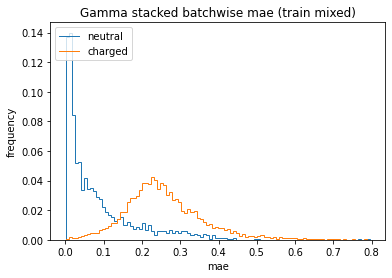

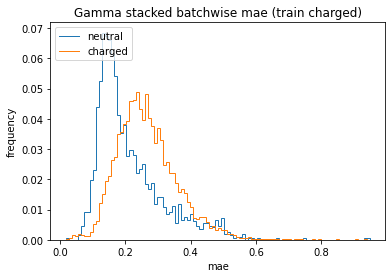

cellwise:
mae (train mixed): 0.1663820487083533
mae (neutral): 0.04080020988788398
mae (charged): 0.2155576303715293
mae (train charged): 0.20415677213017483
mae (neutral): 0.1579552207293149
mae (charged): 0.22224846584335914


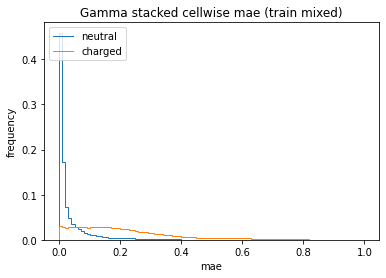

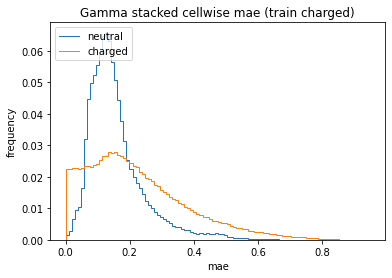

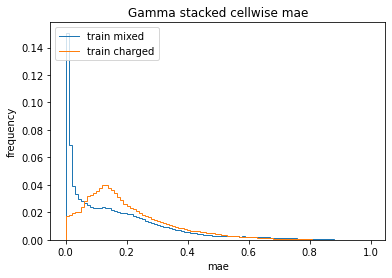

In [53]:
# plot mae seperate for pi+/- and pi0 - clusterwise
mae_tr_m_tst_m = np.array(mae_tr_m_tst_m)
mae_tr_c_tst_m = np.array(mae_tr_c_tst_m)

neutral_cut = np.array(processed_event_data["truth_particle"])[:len(mae)] == 0
charged_cut = np.array(processed_event_data["truth_particle"])[:len(mae)] == 1


print("mae (train mixed):", np.mean(mae_tr_m_tst_m))
print("mae (neutral):", np.mean(mae_tr_m_tst_m[neutral_cut]))
print("mae (charged):", np.mean(mae_tr_m_tst_m[charged_cut]))
print("mae (train charged):", np.mean(mae_tr_c_tst_m))
print("mae (neutral):", np.mean(mae_tr_c_tst_m[neutral_cut]))
print("mae (charged):", np.mean(mae_tr_c_tst_m[charged_cut]))

pu.plot_overlay_hist([mae_tr_m_tst_m[neutral_cut], mae_tr_m_tst_m[charged_cut]], 100, "Gamma stacked batchwise mae (train mixed)", "mae", "frequency", ["neutral", "charged"])
pu.plot_overlay_hist([mae_tr_c_tst_m[neutral_cut], mae_tr_c_tst_m[charged_cut]], 100, "Gamma stacked batchwise mae (train charged)", "mae", "frequency", ["neutral", "charged"])

# plot pointwise loss comparison
unmasked_cut = truth != -1
cellwise_mae_tr_m_tst_m = np.abs(truth[unmasked_cut] - preds_train_mixed_test_mixed[unmasked_cut])
cellwise_mae_tr_c_tst_m = np.abs(truth[unmasked_cut] - preds_train_charged_test_mixed[unmasked_cut])

cellwise_neutral_cut = []
for clus_idx in range(len(mae)):
    cellwise_neutral_cut.extend(np.tile(not processed_event_data["truth_particle"][clus_idx], len(processed_event_data["truth_EM_frac"][clus_idx])))

cellwise_neutral_cut = np.array(cellwise_neutral_cut)
print("cellwise:")
print("mae (train mixed):", np.mean(cellwise_mae_tr_m_tst_m))
print("mae (neutral):", np.mean(cellwise_mae_tr_m_tst_m[cellwise_neutral_cut]))
print("mae (charged):", np.mean(cellwise_mae_tr_m_tst_m[~cellwise_neutral_cut]))
print("mae (train charged):", np.mean(cellwise_mae_tr_c_tst_m))
print("mae (neutral):", np.mean(cellwise_mae_tr_c_tst_m[cellwise_neutral_cut]))
print("mae (charged):", np.mean(cellwise_mae_tr_c_tst_m[~cellwise_neutral_cut]))

pu.plot_overlay_hist([cellwise_mae_tr_m_tst_m[cellwise_neutral_cut], cellwise_mae_tr_m_tst_m[~cellwise_neutral_cut]], 100, "Gamma stacked cellwise mae (train mixed)", "mae", "frequency", ["neutral", "charged"])
pu.plot_overlay_hist([cellwise_mae_tr_c_tst_m[cellwise_neutral_cut], cellwise_mae_tr_c_tst_m[~cellwise_neutral_cut]], 100, "Gamma stacked cellwise mae (train charged)", "mae", "frequency", ["neutral", "charged"])

pu.plot_overlay_hist([cellwise_mae_tr_m_tst_m, cellwise_mae_tr_c_tst_m], 100, "Gamma stacked cellwise mae", "mae", "frequency", ["train mixed", "train charged"])


In [12]:
# find most and least erroneous cluster predictions
ranked_mae = np.argsort(mae)
print(len(mae))
print("greatest error:", mae[ranked_mae[0]], "idx:", ranked_mae[0])
print("least error:", mae[ranked_mae[-1]], "idx:", ranked_mae[-1])

9280
greatest error: 2.9802322387695312e-06 idx: 2534
least error: 0.9854458579793572 idx: 4861


In [13]:
# filter and order ranks
mae = np.array(mae)
processed_event_data["truth_particle"] = np.array(processed_event_data["truth_particle"][:len(mae)]) # NOTE: splice at len(mae) since preds needs to be multiple of BS so not all computed

neutral_cut = processed_event_data["truth_particle"] == 0
charged_cut = processed_event_data["truth_particle"] == 1

mae_neutral = np.sort(mae[neutral_cut])
mae_charged = np.sort(mae[charged_cut])

ranked_mae_neutral = np.searchsorted(mae, mae_neutral, sorter=ranked_mae)
ranked_mae_charged = np.searchsorted(mae, mae_charged, sorter=ranked_mae)

# filter and order ranks by < 0.5 EM frac
truth_EM_frac = np.array([np.mean(clus_truth_EM_frac) for clus_truth_EM_frac in processed_event_data["truth_EM_frac"]])[:len(mae)]

em_cut = truth_EM_frac > 0.5
had_cut = truth_EM_frac <= 0.5

mae_em = np.sort(mae[em_cut])
mae_had = np.sort(mae[had_cut])

ranked_mae_em = np.searchsorted(mae, mae_em, sorter=ranked_mae)
ranked_mae_had = np.searchsorted(mae, mae_had, sorter=ranked_mae)


cluster idx: 5566
mean absolute error: 0.01036302131765029 [rank 700/1958]
mean truth EM frac: 0.99996006
particle: 0
num hits: 34


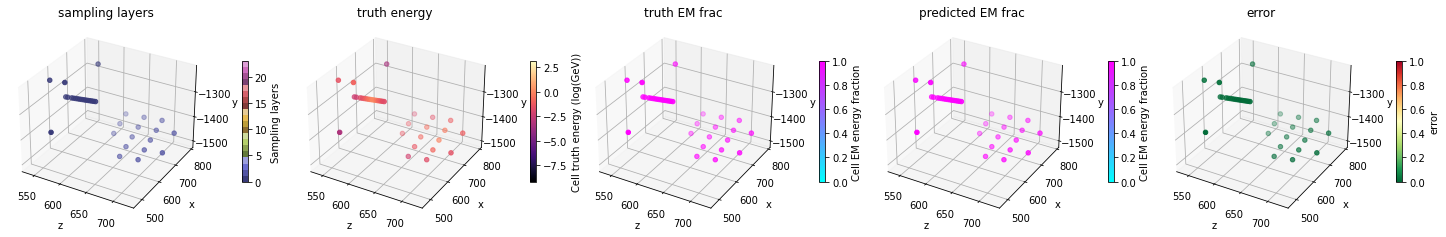

cluster idx: 8548
mean absolute error: 0.010490022644852147 [rank 701/1958]
mean truth EM frac: 0.9893388
particle: 0
num hits: 330


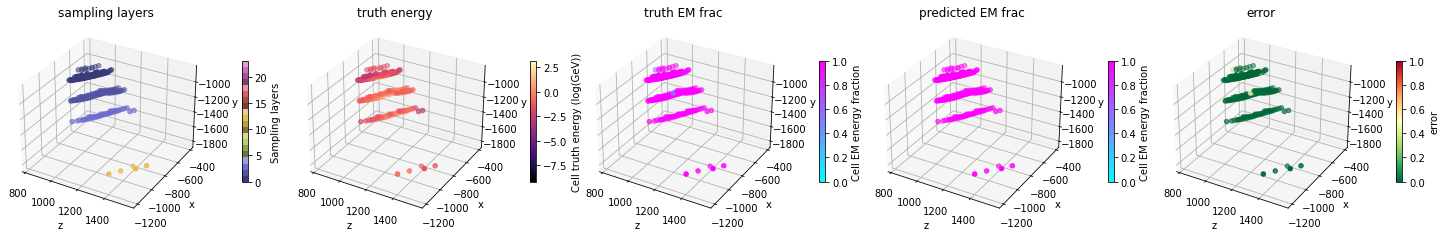

cluster idx: 2265
mean absolute error: 0.010490436302988152 [rank 702/1958]
mean truth EM frac: 0.99998224
particle: 0
num hits: 57


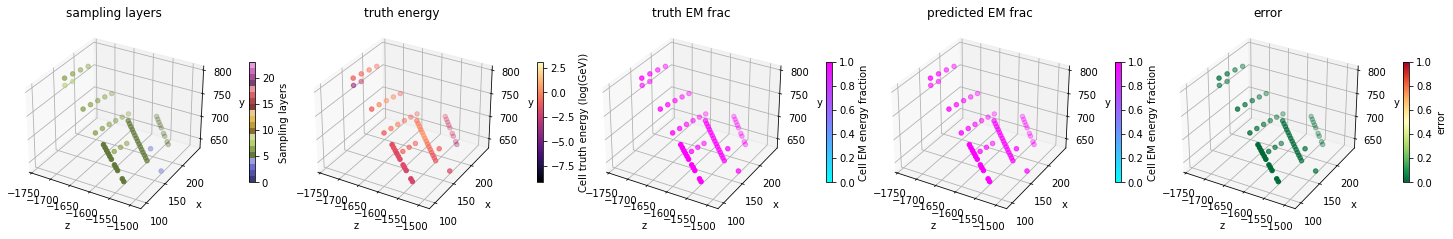

cluster idx: 4473
mean absolute error: 0.010498438562665666 [rank 703/1958]
mean truth EM frac: 1.0
particle: 0
num hits: 21


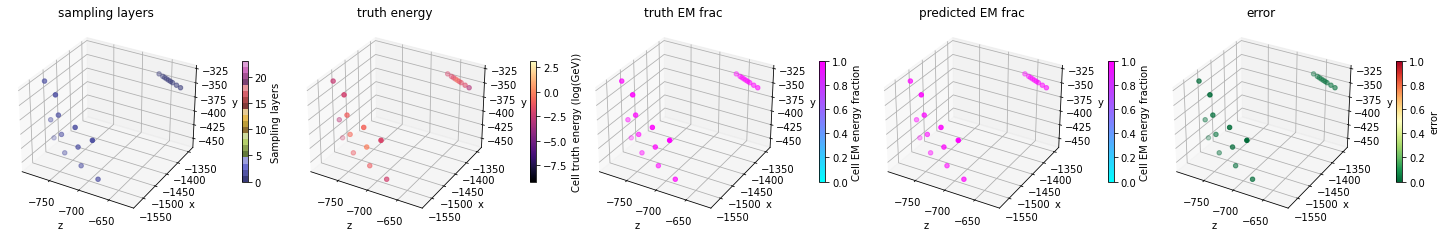

cluster idx: 8910
mean absolute error: 0.010517945913510901 [rank 704/1958]
mean truth EM frac: 0.99587333
particle: 0
num hits: 214


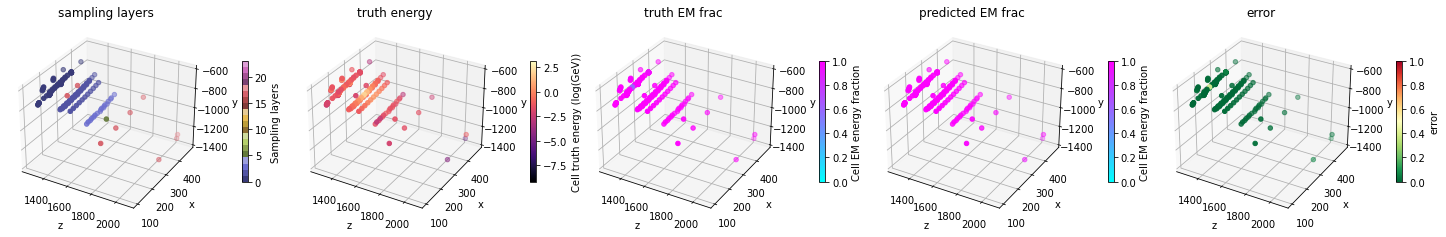

In [14]:
rank_by = ranked_mae_neutral # ranked_mae_charged, ranked_mae_neutral, ranked_mae_em, ranked_mae_had

tot_clus = len(rank_by)
start_rank = 700
num_clus = 5
clus_idxs = [ranked_mae[idx] for idx in rank_by[start_rank:start_rank+num_clus]]

#clus_idxs = [ 197, 1112, 1610, 1887, 3089, 3391, 3392, 3492, 3730, 3773, 3928, 3930, 4169, 5004, 5777, 5778, 6186, 6387, 6388, 6970, 7723, 8934, 9037] # neutral pions with EM frac < 0.8
for i, cluster_idx in enumerate(clus_idxs):
    print("cluster idx:", cluster_idx)
    print("mean absolute error:", mae[cluster_idx], "[rank " + str(start_rank + i)+"/" + str(tot_clus) + "]")
    print("mean truth EM frac:", truth_EM_frac[cluster_idx])
    print("particle:", processed_event_data["truth_particle"][cluster_idx])
    print("num hits:", len(processed_event_data["z"][cluster_idx]))
    x = [processed_event_data["z"][cluster_idx]]
    y = [processed_event_data["x"][cluster_idx]]
    z = [processed_event_data["y"][cluster_idx]]
    clus_truth = np.array(processed_event_data["truth_EM_frac"][cluster_idx])
    clus_preds = np.squeeze(preds[cluster_idx][:len(processed_event_data["x"][cluster_idx])])
    cell_data = [processed_event_data["cell_geo_sampling"][cluster_idx], np.log10(processed_event_data["cluster_cell_truth_E"][cluster_idx]), clus_truth, clus_preds, np.abs(clus_truth - clus_preds)]
    title = ["sampling layers", "truth energy", "truth EM frac", "predicted EM frac", "error"]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]
    colour_theme = [plt.cm.tab20b, plt.cm.magma, plt.cm.cool, plt.cm.cool, plt.cm.RdYlGn_r]
    bar_label = ["Sampling layers", "Cell truth energy (log(GeV))", "Cell EM energy fraction", "Cell EM energy fraction", "error"]
    vmin = [0, -9.15, 0, 0, 0]
    vmax = [23, 3.1, 1, 1, 1]

    plot_proccessed_cells_in_line(x, y, z, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, vmin, vmax)

    # plot for spherical coords too
    """
    x = [processed_event_data["cell_geo_eta"][cluster_idx]]
    y = [processed_event_data["cell_geo_phi"][cluster_idx]]
    z = [processed_event_data["cell_geo_rPerp"][cluster_idx]]
    xlabel = ["eta"]
    ylabel = ["phi"]
    zlabel = ["r perp"]
    plot_proccessed_cells_in_line(x, y, z, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, vmin, vmax)
    """


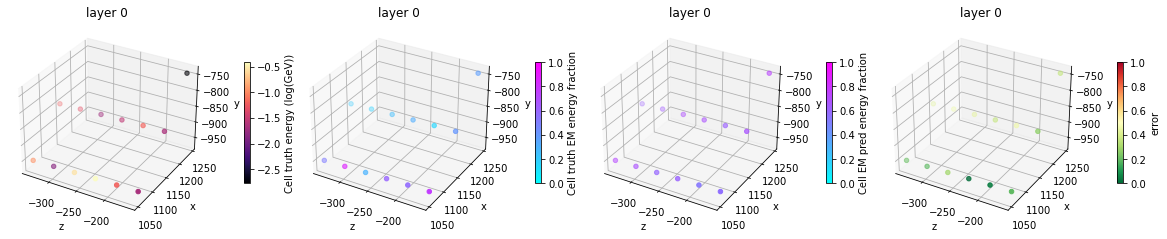

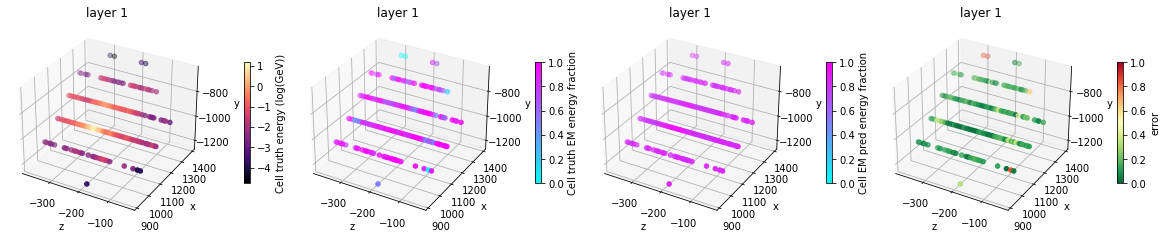

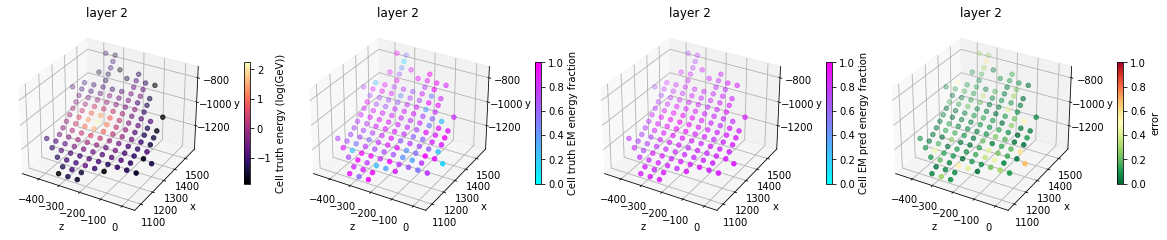

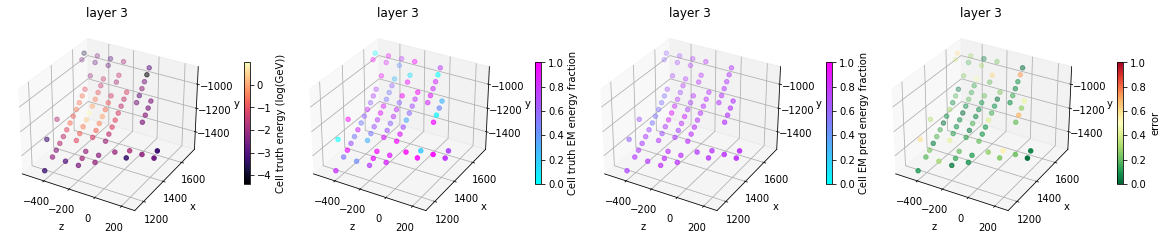

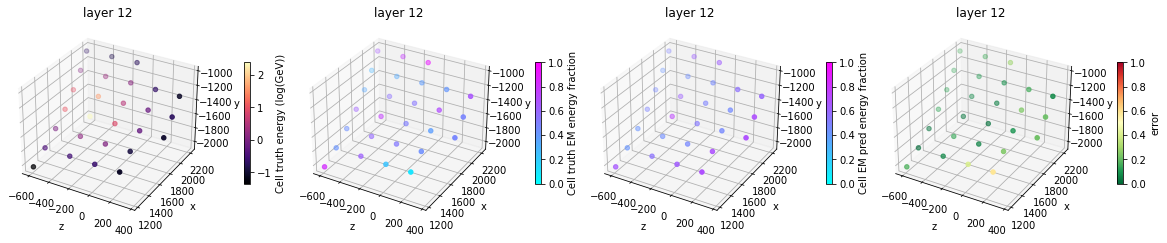

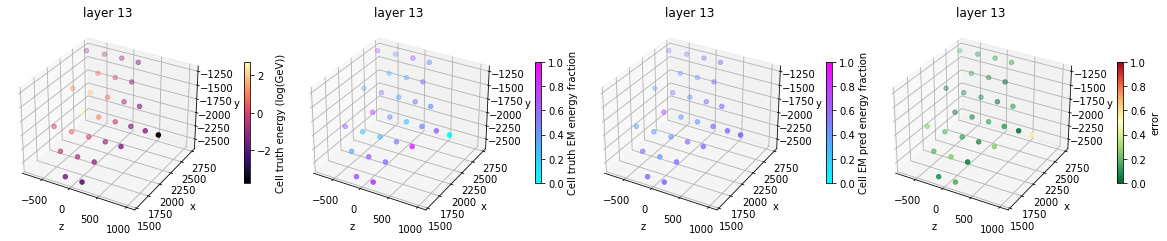

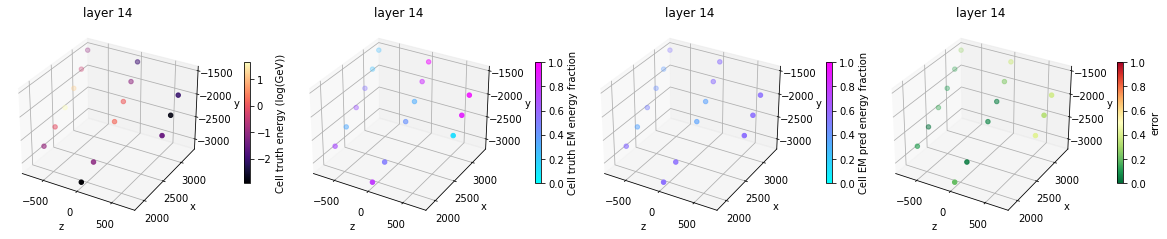

In [15]:
cluster_idx = 6828 # good angle of mixed EM/nonEM - 6828, 8896

for layer in np.unique(processed_event_data["cell_geo_sampling"][cluster_idx]):
    cut_layer = (processed_event_data["cell_geo_sampling"][cluster_idx] == layer)
    x = [np.array(processed_event_data["z"][cluster_idx])[cut_layer]]
    y = [np.array(processed_event_data["x"][cluster_idx])[cut_layer]]
    z = [np.array(processed_event_data["y"][cluster_idx])[cut_layer]]
    truth_cut = np.array(processed_event_data["truth_EM_frac"][cluster_idx])[cut_layer]
    preds_cut = np.squeeze(preds[cluster_idx][:len(processed_event_data["x"][cluster_idx])][cut_layer])
    cell_data = [np.log10(processed_event_data["cluster_cell_truth_E"][cluster_idx])[cut_layer], truth_cut, preds_cut, np.abs(truth_cut - preds_cut)]
    title = ["layer " + str(layer)]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]
    colour_theme = [plt.cm.magma, plt.cm.cool, plt.cm.cool, plt.cm.RdYlGn_r]
    bar_label = ["Cell truth energy (log(GeV))", "Cell truth EM energy fraction", "Cell EM pred energy fraction", "error"]
    vmin = [None, 0, 0, 0]
    vmax = [None, 1, 1, 1]

    plot_proccessed_cells_in_line(x, y, z, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, vmin, vmax)
    

clusterwise:
mean mae (spherical): 0.22708917249714855
mean mae (cartesian): 0.210828877171577
mean mae_630 (cartesian): 0.210828877171577


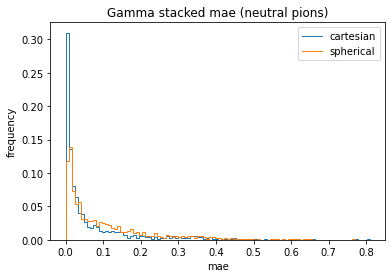

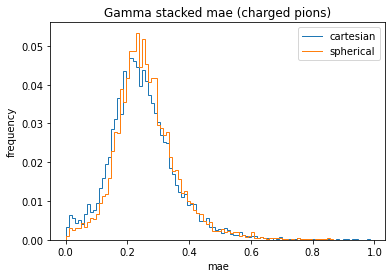

cellwise:
mean mae (spherical): 0.17361341911180292
mean mae (cartesian): 0.157975780472871


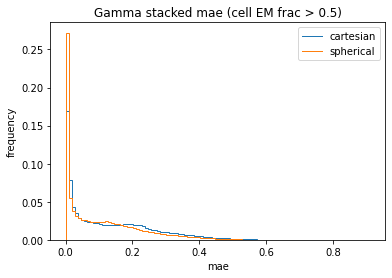

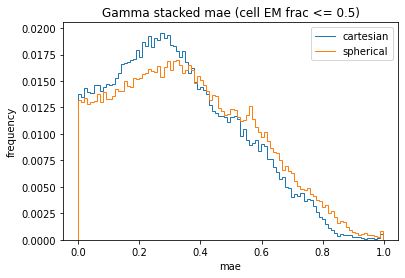

In [16]:
# compare trainning on cartesian and spherical data
mae_sp = np.array(mae_sp)
mae_ca = np.array(mae_ca)

print("clusterwise:")
print("mean mae (spherical):", np.mean(mae_sp))
print("mean mae (cartesian):", np.mean(mae_ca))
print("mean mae_630 (cartesian):", np.mean(mae_ca_630))

neutral_cut = processed_event_data["truth_particle"] == 0
charged_cut = processed_event_data["truth_particle"] == 1

pu.plot_overlay_hist([mae_ca[neutral_cut], mae_sp[neutral_cut]], 100, "Gamma stacked mae (neutral pions)", "mae", "frequency", ["cartesian", "spherical"])
pu.plot_overlay_hist([mae_ca[charged_cut], mae_sp[charged_cut]], 100, "Gamma stacked mae (charged pions)", "mae", "frequency", ["cartesian", "spherical"])

print("cellwise:")
unmasked_cut = truth != -1
cellwise_mae_sp = np.abs(truth[unmasked_cut] - preds_sp[unmasked_cut])
cellwise_mae_ca = np.abs(truth[unmasked_cut] - preds_ca[unmasked_cut])
print("mean mae (spherical):", np.mean(cellwise_mae_sp))
print("mean mae (cartesian):", np.mean(cellwise_mae_ca))

truth_EM_frac_cellwise = np.array([cell_data for clus_data in processed_event_data["truth_EM_frac"][:len(mae)] for cell_data in clus_data])
em_cut_cellwise = truth_EM_frac_cellwise > 0.5
had_cut_cellwise = truth_EM_frac_cellwise <= 0.5
pu.plot_overlay_hist([cellwise_mae_sp[em_cut_cellwise], cellwise_mae_ca[em_cut_cellwise]], 100, "Gamma stacked mae (cell EM frac > 0.5)", "mae", "frequency", ["cartesian", "spherical"])
pu.plot_overlay_hist([cellwise_mae_sp[had_cut_cellwise], cellwise_mae_ca[had_cut_cellwise]], 100, "Gamma stacked mae (cell EM frac <= 0.5)", "mae", "frequency", ["cartesian", "spherical"])



/tmp/ipykernel_34581/3067386819.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed_event_data["cluster_cell_truth_E"] = np.array(processed_event_data["cluster_cell_truth_E"])


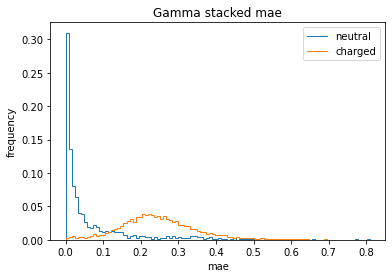

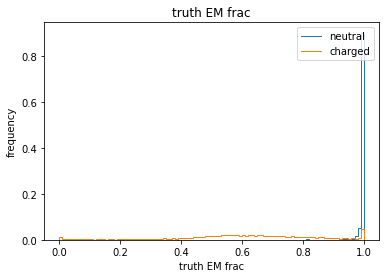

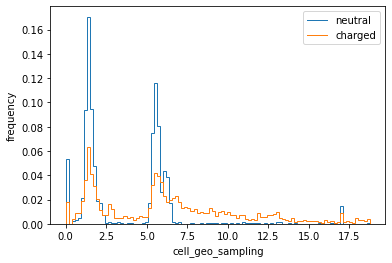

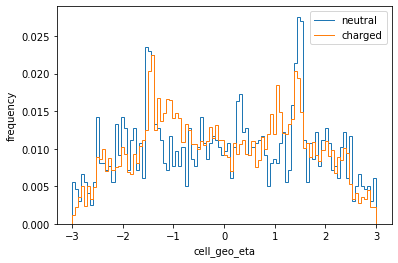

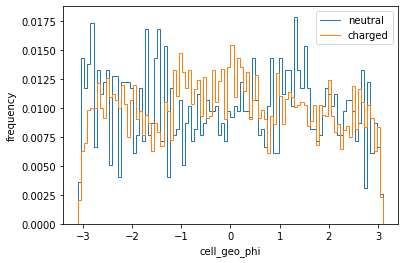

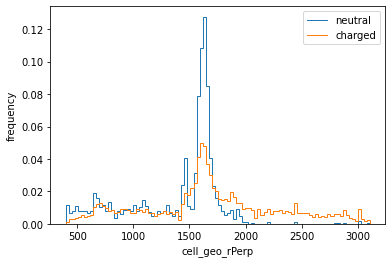

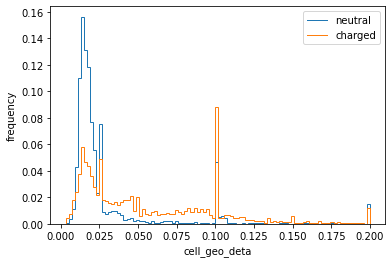

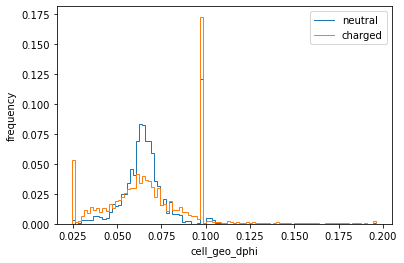

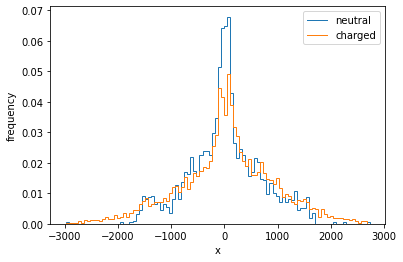

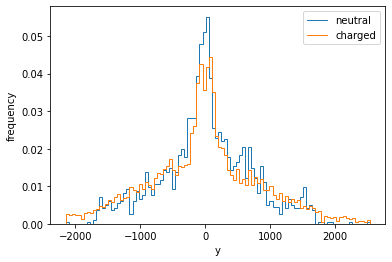

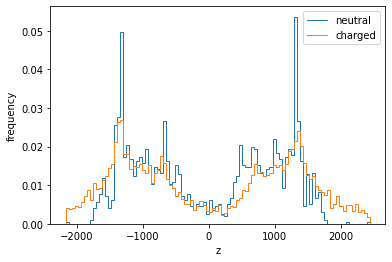

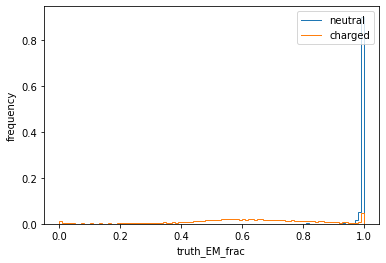

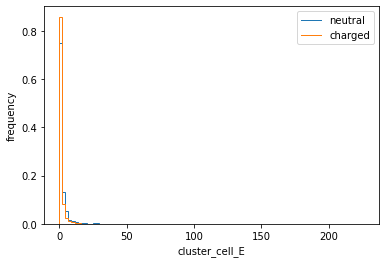

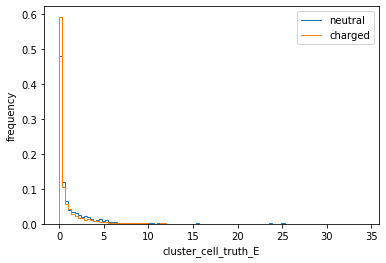

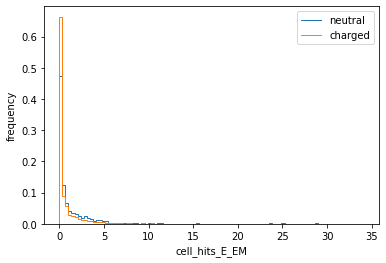

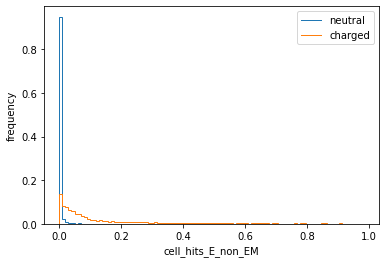

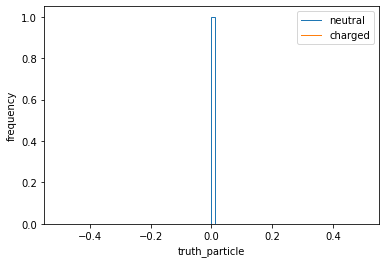

num em: 7440
num had: 1840


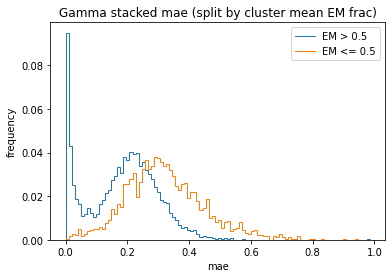

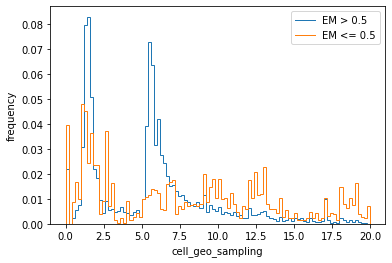

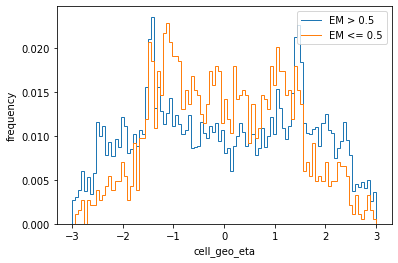

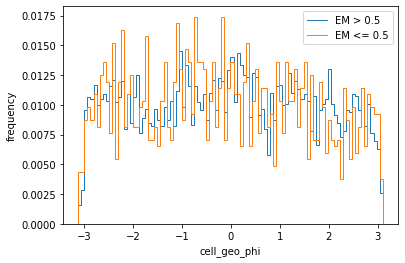

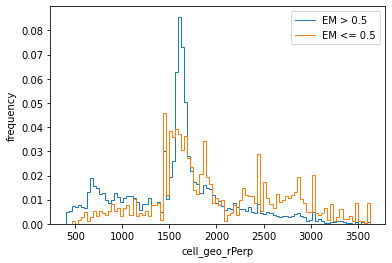

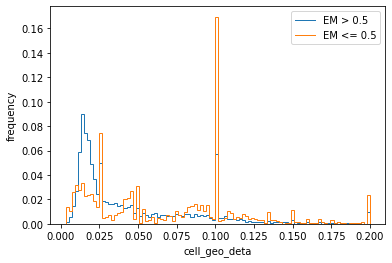

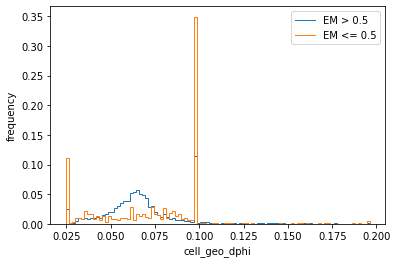

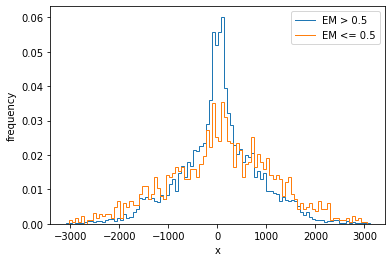

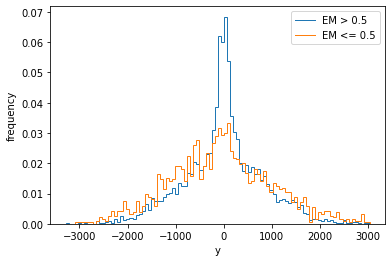

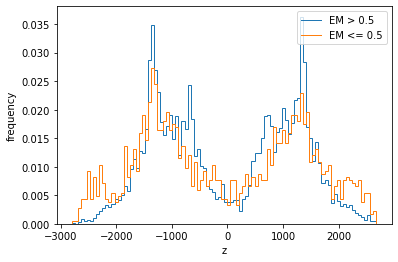

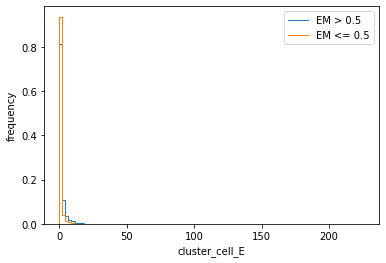

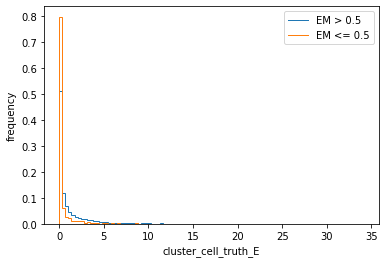

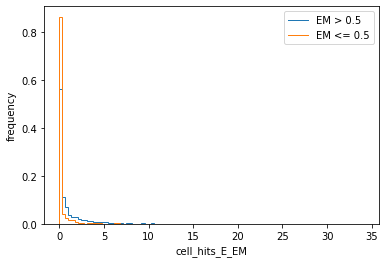

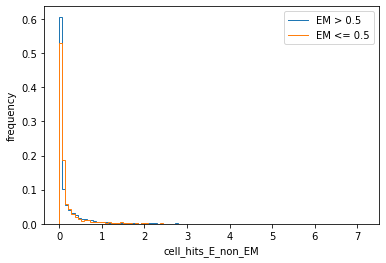

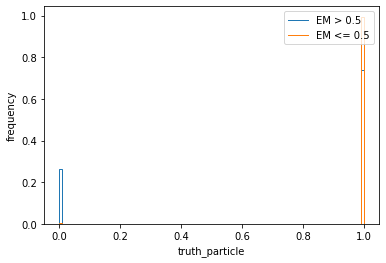

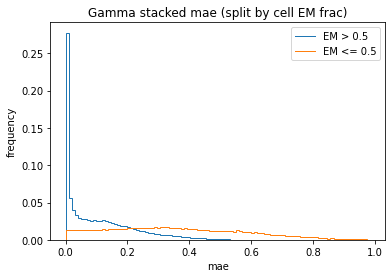

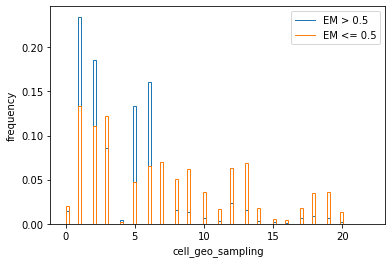

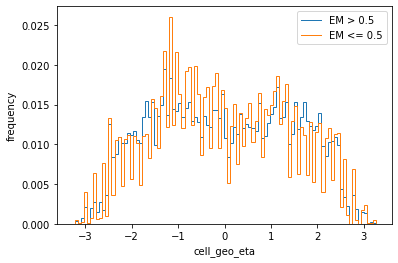

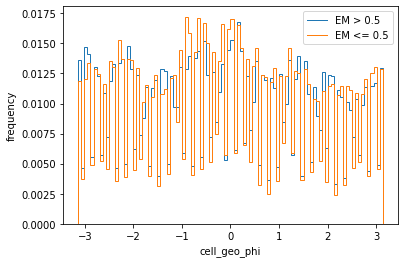

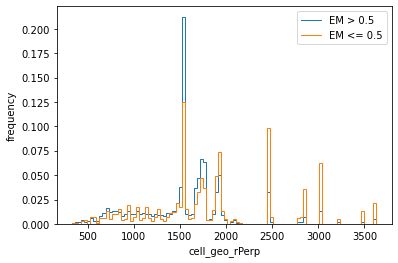

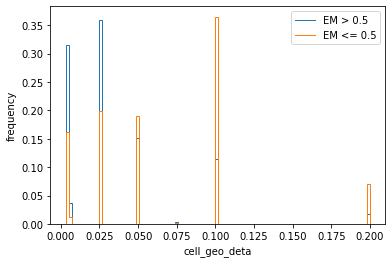

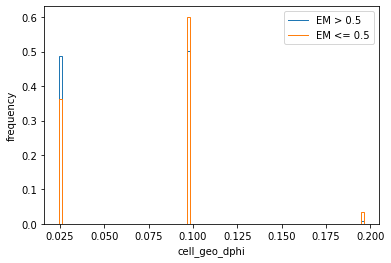

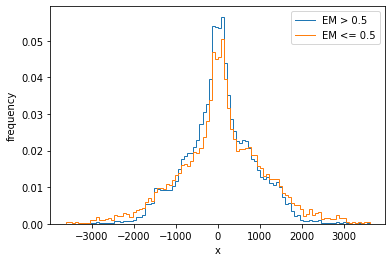

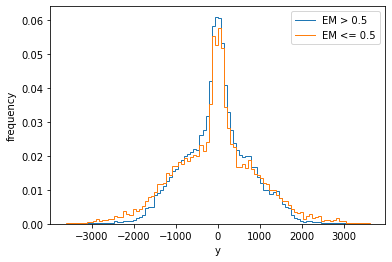

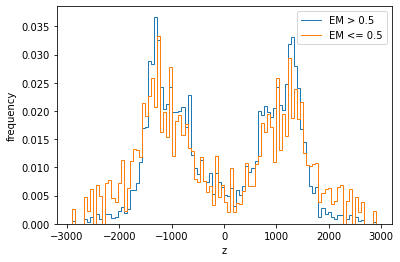

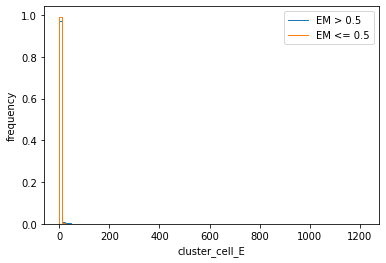

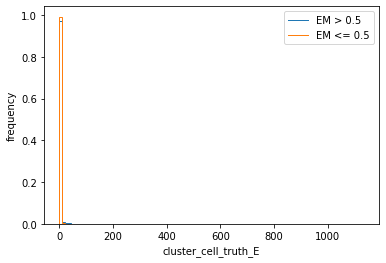

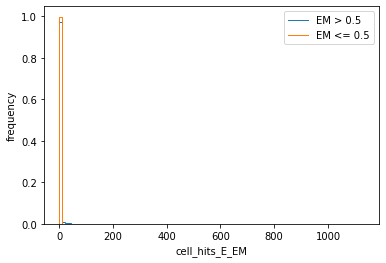

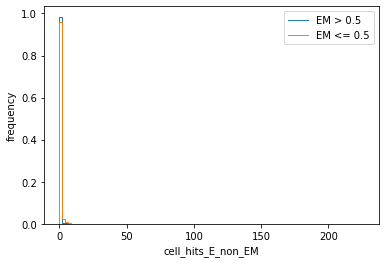

In [17]:
# plot mae seperate for pi+/- and pi0
mae = np.array(mae)
processed_event_data["truth_particle"] = np.array(processed_event_data["truth_particle"][:len(mae)]) # NOTE: splice at len(mae) since preds needs to be multiple of BS so not all computed
processed_event_data["cluster_cell_truth_E"] = np.array(processed_event_data["cluster_cell_truth_E"])


neutral_cut = processed_event_data["truth_particle"] == 0
charged_cut = processed_event_data["truth_particle"] == 1
pu.plot_overlay_hist([mae[neutral_cut], mae[charged_cut]], 100, "Gamma stacked mae", "mae", "frequency", ["neutral", "charged"])

truth_EM_frac = np.array([np.mean(clus_truth_EM_frac) for clus_truth_EM_frac in processed_event_data["truth_EM_frac"]])[:len(mae)]
"""
print("most hadronic:", np.where((truth_EM_frac < 0.8) & neutral_cut))
print("num cells in neutral clus w EM frac < 1:", len(truth_EM_frac[neutral_cut][truth_EM_frac[neutral_cut] < 1]), "frac:", len(truth_EM_frac[neutral_cut][truth_EM_frac[neutral_cut] < 1]) / len(truth_EM_frac[neutral_cut]))
print("num cells in neutral clus w EM frac < 0.99:", len(truth_EM_frac[neutral_cut][truth_EM_frac[neutral_cut] < 0.99]), "frac:", len(truth_EM_frac[neutral_cut][truth_EM_frac[neutral_cut] < 0.99]) / len(truth_EM_frac[neutral_cut]))
print("num cells in neutral clus w EM frac < 0.8:", len(truth_EM_frac[neutral_cut][truth_EM_frac[neutral_cut] < 0.8]), "frac:", len(truth_EM_frac[neutral_cut][truth_EM_frac[neutral_cut] < 0.8]) / len(truth_EM_frac[neutral_cut]))
"""
pu.plot_overlay_hist([truth_EM_frac[neutral_cut], truth_EM_frac[charged_cut]], 100, "truth EM frac", "truth EM frac", "frequency", ["neutral", "charged"])

# filter by clus from neutral or charged pion
for key in processed_event_data.keys():
    data = np.array([np.mean(clus_truth_data) for clus_truth_data in processed_event_data[key]])[:len(mae)]
    pu.plot_overlay_hist([data[neutral_cut], data[charged_cut]], 100, "", key, "frequency", ["neutral", "charged"])

# filter by clus mean truth_EM_frac more em or had clus
em_cut = truth_EM_frac > 0.5
had_cut = truth_EM_frac <= 0.5
print("num em:", len(mae[em_cut]))
print("num had:", len(mae[had_cut]))
pu.plot_overlay_hist([mae[em_cut], mae[had_cut]], 100, "Gamma stacked mae (split by cluster mean EM frac)", "mae", "frequency", ["EM > 0.5", "EM <= 0.5"])

for key in processed_event_data.keys():
    if key != 'truth_EM_frac':
        data = np.array([np.mean(clus_truth_data) for clus_truth_data in processed_event_data[key]])[:len(mae)]
        pu.plot_overlay_hist([data[em_cut], data[had_cut]], 100, "", key, "frequency", ["EM > 0.5", "EM <= 0.5"])

# filter by cell majority EM or had
cellwise_mae = np.abs(preds[truth != -1] - truth[truth != -1])
truth_EM_frac_cellwise = np.array([cell_data for clus_data in processed_event_data["truth_EM_frac"][:len(mae)] for cell_data in clus_data])

em_cut_cellwise = truth_EM_frac_cellwise > 0.5
had_cut_cellwise = truth_EM_frac_cellwise <= 0.5

pu.plot_overlay_hist([cellwise_mae[em_cut_cellwise], cellwise_mae[had_cut_cellwise]], 100, "Gamma stacked mae (split by cell EM frac)", "mae", "frequency", ["EM > 0.5", "EM <= 0.5"])

for key in processed_event_data.keys():
    if key != "truth_particle" and key != 'truth_EM_frac':
        data = np.array([cell_data for clus_data in processed_event_data[key][:len(mae)] for cell_data in clus_data])
        pu.plot_overlay_hist([data[em_cut_cellwise], data[had_cut_cellwise]], 100, "", key, "frequency", ["EM > 0.5", "EM <= 0.5"])


layer: 1
num cells: 8
max: 1526.4908
min: 1526.4908


/tmp/ipykernel_34581/658050921.py:12: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


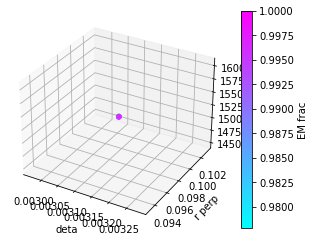

layer: 2
num cells: 9
max: 1741.6384
min: 1706.8102


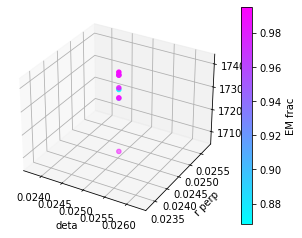

layer: 3
num cells: 26
max: 1946.93
min: 1905.8849


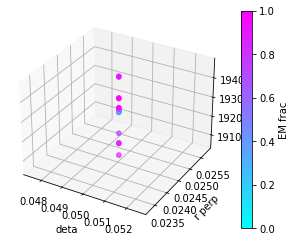

layer: 12
num cells: 23
max: 2450.0
min: 2450.0


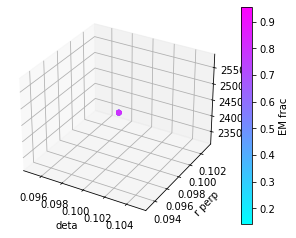

layer: 13
num cells: 24
max: 3020.0
min: 2795.0


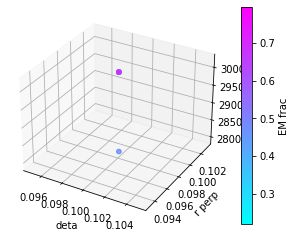

layer: 14
num cells: 8
max: 3630.0
min: 3630.0


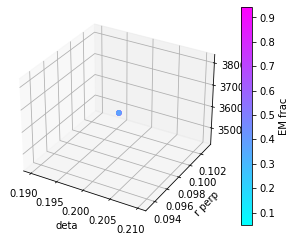

layer: 15
num cells: 3
max: 3215.0
min: 3215.0


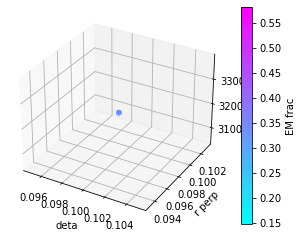

layer: 16
num cells: 3
max: 3630.0
min: 3630.0


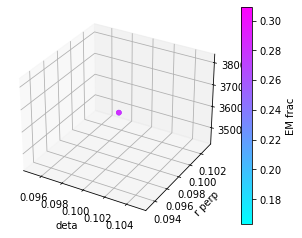

layer: 17
num cells: 3
max: 2809.0
min: 2809.0


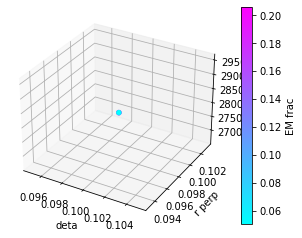

layer: 19
num cells: 5
max: 2870.0
min: 2870.0


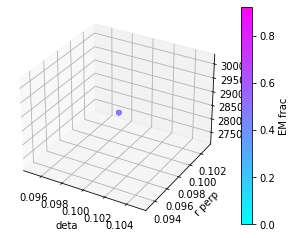

layer: 20
num cells: 4
max: 3480.0
min: 3479.9998


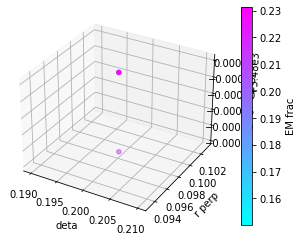

In [18]:
# deta investigate - is there an error - all set to the same???
clus_idxs = [0]

for clus_idx in clus_idxs:
    for layer in np.unique(processed_event_data["cell_geo_sampling"][clus_idx]):
        print("layer:", layer)
        cut_layer = (processed_event_data["cell_geo_sampling"][clus_idx] == layer)
        print("num cells:", len(processed_event_data["cell_geo_dphi"][clus_idx][cut_layer]))
        print("max:", np.max(processed_event_data["cell_geo_rPerp"][clus_idx][cut_layer]))
        print("min:", np.min(processed_event_data["cell_geo_rPerp"][clus_idx][cut_layer]))
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        p = ax.scatter(processed_event_data["cell_geo_deta"][clus_idx][cut_layer], processed_event_data["cell_geo_dphi"][clus_idx][cut_layer], processed_event_data["cell_geo_rPerp"][clus_idx][cut_layer], c=processed_event_data["truth_EM_frac"][clus_idx][cut_layer], cmap=plt.cm.cool)
        plt.xlabel("deta")
        plt.ylabel("dphi")
        plt.ylabel("r perp")
        plt.colorbar(p, label="EM frac")
        plt.show()

        """
        fig = plt.figure()
        plt.scatter(processed_event_data["cell_geo_dphi"][clus_idx][cut_layer], processed_event_data["cell_geo_rPerp"][clus_idx][cut_layer], c=processed_event_data["truth_EM_frac"][clus_idx][cut_layer], cmap=plt.cm.cool)
        plt.xlabel("dphi")
        plt.ylabel("r perp")
        plt.colorbar(label="EM frac")
        plt.show()
        """

        
